# Modelos ensemble

Durante los últimos cuatro cuadernillos hemos visto modelos de aprendizaje supervisado que nos eran últiles para problemas de clasificación y regresión.

Durante este cuadernillo, veremos cómo podemos crear modelos ensemble con ellos.

**ATENCIÓN. Durante el siguiente cuadernillo se ejecutarán celdas con un alto coste computacional. Si bien es cierto que pocas de ellas usarán realmente una GPU, es buena idea configurar el entorno para que use una de ellas, dado que estos entornos suelen ser más rápidos. Para configurar el entorno (debería estarlo, pero compruébalo), accede a _Entorno de ejecución_ --> Cambiar tipo de entorno de ejecución --> T4 GPU.**

**Aquellas celdas computacionalmente costosas estarán marcadas con el siguiente mensaje: 🐭 la siguiente celda puede tardar en ejecutarse (XX minutos). Ejecútalas bajo tu responsabilidad.**

## Introducción teórica

Un modelo ensemble es un fusión de modelos clásicos que permite elegir un resultado dependiendo de un criterio elegido por el programador (democracia, democracia ponderada...). Básicamente, el resultado del modelo será una combinación de los resultados de los modelos el ensemble.

Es importante destacar que existen muchas formas de crear modelos ensemble y que, realmente, el límite está en la imaginación que tenga el programador para fusionarlos.

Durante el cuadernillo ```406``` hablaremos sobre los ```RandomForest```, que son un ejemplo de modelos ensemble. En este caso particular, lo que buscaremos será **sobreentrenar** (sí, antiintuitivo) cada uno de los modelos que conforman el bosque para que sean extremadamente buenos en un área muy particular del problema. Después, se usarán esos modelos sobreajustados como si fuesen uno solo para dar solución al nuevo problema.

Durante este cuadernillo, daremos solución a [esta competición real de Kaggle](https://www.kaggle.com/competitions/playground-series-s3e24/overview).

## El conjunto de datos y limpieza

Para cargar el conjunto de datos, dirígete al enlace, descarga el conjunto de datos en formato ```zip``` y súbelo a Google Colab.

In [ ]:
%%capture
!unzip playground-series-s3e24.zip

In [ ]:
import pandas as pd

In [ ]:
train_val = pd.read_csv("train.csv")
train_val.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


## Conjuntos de datos

Vamos a dividir el conjunto de entrenamiento en entrenamiento y validación.

In [ ]:
from sklearn.model_selection import train_test_split

random_seed = 33

In [ ]:
train, val = train_test_split(train_val, test_size=0.15, random_state=random_seed)

## Limpieza de datos

Columnas inútiles. Tenemos una columna ```id``` que no necesitamos para nada en el entrenamiento.

In [ ]:
train = train.drop(columns="id")
val = val.drop(columns="id")

Datos sin sentido. Son datos médicos, así que no controlo qué datos pueden tener o no sentido (más allá de los evidentes, como ```age```).

In [ ]:
train.describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,135367.000000,135367.000000,135367.000000,135367.000000,135367.000000,135367.000000,135367.000000,135367.000000,135367.000000,135367.000000,...,135367.000000,135367.000000,135367.000000,135367.000000,135367.000000,135367.000000,135367.000000,135367.000000,135367.000000,135367.000000
mean,44.297214,165.267200,67.152105,83.004576,1.005707,1.001044,1.024097,1.023529,122.511491,76.882401,...,55.851241,114.589176,14.796780,1.074331,0.892941,25.522661,26.570013,36.294769,0.197929,0.437285
std,11.840802,8.816742,12.594423,8.968346,0.399835,0.391239,0.153352,0.151576,12.731839,8.992300,...,13.961877,28.374666,1.431559,0.348729,0.179545,9.560375,18.185182,31.319507,0.398440,0.496053
min,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,44.000000,...,9.000000,1.000000,4.900000,1.000000,0.100000,6.000000,3.000000,2.000000,0.000000,0.000000
25%,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,70.000000,...,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,78.000000,...,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000
75%,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,...,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
max,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,133.000000,...,136.000000,1860.000000,21.000000,6.000000,9.900000,778.000000,2914.000000,926.000000,1.000000,1.000000


Valores atípicos. Vamos a ver si tenemos alguno.

In [ ]:
def outlier_eliminator(df, threshold: float = 0.05):
  s_df = df.describe() # statistical dataframe

  for column in s_df.columns:
    # datos necesarios
    n = s_df.loc["count", column]
    q1 = s_df.loc["25%", column]
    q3 = s_df.loc["75%", column]
    mean = s_df.loc["mean", column] # 50% no es la media, es la mediana
    iqr = (q3 - q1) * 1.5

    # calculos
    _range = [mean - iqr, mean + iqr]
    outliers = df[(df[column] < _range[0]) | (df[column] > _range[1])]

    # outliers
    print(f"Outliers para la columna {column}: {len(outliers)} de {n}. BORRADOS: ", end="")
    if len(outliers) != 0 and len(outliers) / n < threshold:
      print("Sí.")
      df = df[(df[column] > _range[0]) & (df[column] < _range[1])] # fíjate que le doy la vuelta
    else:
      print("No.")

    print("### --- ###")

  return df

In [ ]:
train = outlier_eliminator(train, threshold=0.025)

Outliers para la columna age: 7225 de 135367.0. BORRADOS: No.
### --- ###
Outliers para la columna height(cm): 13873 de 135367.0. BORRADOS: No.
### --- ###
Outliers para la columna weight(kg): 8932 de 135367.0. BORRADOS: No.
### --- ###
Outliers para la columna waist(cm): 5750 de 135367.0. BORRADOS: No.
### --- ###
Outliers para la columna eyesight(left): 6711 de 135367.0. BORRADOS: No.
### --- ###
Outliers para la columna eyesight(right): 6987 de 135367.0. BORRADOS: No.
### --- ###
Outliers para la columna hearing(left): 135367 de 135367.0. BORRADOS: No.
### --- ###
Outliers para la columna hearing(right): 135367 de 135367.0. BORRADOS: No.
### --- ###
Outliers para la columna systolic: 7439 de 135367.0. BORRADOS: No.
### --- ###
Outliers para la columna relaxation: 5392 de 135367.0. BORRADOS: No.
### --- ###
Outliers para la columna fasting blood sugar: 13765 de 135367.0. BORRADOS: No.
### --- ###
Outliers para la columna Cholesterol: 2580 de 135367.0. BORRADOS: Sí.
### --- ###
Outlie

Estadísticos básicos. Vamos a ver si existen nulos.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131381 entries, 149220 to 154644
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  131381 non-null  int64  
 1   height(cm)           131381 non-null  int64  
 2   weight(kg)           131381 non-null  int64  
 3   waist(cm)            131381 non-null  float64
 4   eyesight(left)       131381 non-null  float64
 5   eyesight(right)      131381 non-null  float64
 6   hearing(left)        131381 non-null  int64  
 7   hearing(right)       131381 non-null  int64  
 8   systolic             131381 non-null  int64  
 9   relaxation           131381 non-null  int64  
 10  fasting blood sugar  131381 non-null  int64  
 11  Cholesterol          131381 non-null  int64  
 12  triglyceride         131381 non-null  int64  
 13  HDL                  131381 non-null  int64  
 14  LDL                  131381 non-null  int64  
 15  hemoglobin       

Parece que no vamos a tener que preocuparnos de esto.

Correlación. ¿Habrá columnas correladas?

In [ ]:
train.corr()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
age,1.000000,-0.486032,-0.334903,-0.046495,-0.266962,-0.279769,0.211495,0.212813,0.161801,0.066169,...,0.043142,0.118008,-0.278496,-0.005472,-0.142167,0.034490,-0.129834,-0.048391,-0.118214,-0.202444
height(cm),-0.486032,1.000000,0.687688,0.413880,0.208004,0.217078,-0.089305,-0.092203,0.067151,0.119076,...,-0.308099,-0.076516,0.569083,-0.017747,0.460751,0.059224,0.218031,0.222801,0.099329,0.445268
weight(kg),-0.334903,0.687688,1.000000,0.831894,0.151507,0.162759,-0.069168,-0.071000,0.245127,0.268448,...,-0.442223,0.071470,0.527270,-0.031712,0.393156,0.156602,0.366791,0.294336,0.089955,0.350966
waist(cm),-0.046495,0.413880,0.831894,1.000000,0.048062,0.057463,0.003408,0.005692,0.308541,0.292797,...,-0.452675,0.133049,0.420539,-0.032287,0.297028,0.179126,0.348451,0.296458,0.053390,0.264549
eyesight(left),-0.266962,0.208004,0.151507,0.048062,1.000000,0.455997,-0.065607,-0.068121,-0.030481,0.010327,...,-0.045197,-0.017938,0.133148,-0.011606,0.088072,-0.000188,0.061673,0.041846,0.018567,0.099480
eyesight(right),-0.279769,0.217078,0.162759,0.057463,0.455997,1.000000,-0.070853,-0.079024,-0.027544,0.016899,...,-0.049585,-0.016022,0.140588,-0.011821,0.087353,0.009599,0.072964,0.052347,0.024245,0.109309
hearing(left),0.211495,-0.089305,-0.069168,0.003408,-0.065607,-0.070853,1.000000,0.551998,0.040047,-0.013029,...,-0.001939,-0.007289,-0.051579,-0.008697,-0.007685,-0.003590,-0.034930,-0.022253,-0.017662,-0.038628
hearing(right),0.212813,-0.092203,-0.071000,0.005692,-0.068121,-0.079024,0.551998,1.000000,0.040535,-0.016842,...,0.000340,-0.009193,-0.049988,-0.006900,-0.008409,-0.003286,-0.035976,-0.017098,-0.014629,-0.036628
systolic,0.161801,0.067151,0.245127,0.308541,-0.030481,-0.027544,0.040047,0.040535,1.000000,0.754146,...,-0.121383,0.059195,0.177607,-0.029749,0.070633,0.090258,0.106203,0.158366,0.018915,0.059500
relaxation,0.066169,0.119076,0.268448,0.292797,0.010327,0.016899,-0.013029,-0.016842,0.754146,1.000000,...,-0.131437,0.079100,0.231660,-0.021267,0.094625,0.088698,0.125562,0.186163,0.024498,0.112006


In [ ]:
corr = train.corr()
for column in corr:
  for index in corr.index:
    corr_v = abs(corr.loc[index, column])
    if corr_v > 0.8 and not corr_v == 1.0:
      print(f"Valor correlado en {index} - {column}, valor: {corr.loc[index, column]}")

Valor correlado en waist(cm) - weight(kg), valor: 0.8318937180691987
Valor correlado en weight(kg) - waist(cm), valor: 0.8318937180691987
Valor correlado en LDL - Cholesterol, valor: 0.8615422439306766
Valor correlado en Cholesterol - LDL, valor: 0.8615422439306766


Eliminamos una de las parejas correladas.

In [ ]:
train = train.drop(columns=["waist(cm)", "Cholesterol"])
val = val.drop(columns=["waist(cm)", "Cholesterol"])
train_val = train_val.drop(columns=["waist(cm)", "Cholesterol"])

Variabilidad. Veamos si tenemos problemas de variabilidad.

In [ ]:
def numerical_variability(df, threshold: float = 0.1):
  numerical_df = df.select_dtypes("number")

  for column in numerical_df.columns:
    serie = numerical_df[column].value_counts()
    _max = serie.iloc[0] # primer elemento (el más grande) ; max es una palabra reservada
    prop = _max / len(df) * 100.0 # proportion
    if prop > threshold * 100.0:
      print(f"Cuidado, la proporción de valores idénticos para la columna {column} es de {prop}%, que supera el threshold establecido.")

In [ ]:
numerical_variability(train)

Cuidado, la proporción de valores idénticos para la columna age es de 29.582664159962246%, que supera el threshold establecido.
Cuidado, la proporción de valores idénticos para la columna height(cm) es de 23.629748593784488%, que supera el threshold establecido.
Cuidado, la proporción de valores idénticos para la columna weight(kg) es de 15.216812172231906%, que supera el threshold establecido.
Cuidado, la proporción de valores idénticos para la columna eyesight(left) es de 23.52471057458841%, que supera el threshold establecido.
Cuidado, la proporción de valores idénticos para la columna eyesight(right) es de 23.98596448497119%, que supera el threshold establecido.
Cuidado, la proporción de valores idénticos para la columna hearing(left) es de 97.61304907102244%, que supera el threshold establecido.
Cuidado, la proporción de valores idénticos para la columna hearing(right) es de 97.66480693555386%, que supera el threshold establecido.
Cuidado, la proporción de valores idénticos para l

La mayoría son varaibles categóricas codificadas (como ```age```). Borro las que estén por encima del 90% (binarias) o 50% (multiclase).

In [ ]:
train = train.drop(columns=["hearing(left)", "hearing(right)", "Urine protein"])
val = val.drop(columns=["hearing(left)", "hearing(right)", "Urine protein"])
train_val = train_val.drop(columns=["hearing(left)", "hearing(right)", "Urine protein"])

Estandarización. Voy a estandarizar los datos para tenerlos en el mismo rango.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
X_train, y_train = train.drop(columns="smoking"), train.smoking
X_val, y_val = val.drop(columns="smoking"), val.smoking
X_train_val, y_train_val = train_val.drop(columns="smoking"), train_val.smoking

In [ ]:
ss = StandardScaler().fit(X_train)

# training
X_train_std = ss.transform(X_train)
X_val_std = ss.transform(X_val)

## Prueba inicial

Es un problema de clasificación. Realicemos nuestras pruebas iniciales.

En la competición, se usa la métrica ROC para evaluar los resultados. La importamos.

Esta métrica establece un ratio entre los falsos negativos y los verdaderos positivos. Cuanto más se acerque a uno, mejor.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, RocCurveDisplay

Definimos la función para predecir.

In [ ]:
def evaluate(X_train, y_train, X_test, y_test, model):
  model = model.fit(X_train, y_train)

  # train
  train_pred = model.predict(X_train)
  train_score = roc_auc_score(y_train, train_pred)

  # test
  test_pred = model.predict(X_test)
  test_score = roc_auc_score(y_test, test_pred)

  return model, train_score, test_score, train_pred, test_pred

Resultados iniciales.

In [ ]:
model = RandomForestClassifier(random_state=random_seed)
model, train_score, test_score, train_pred, val_pred = evaluate(X_train_std, y_train, X_val_std, y_val, model)

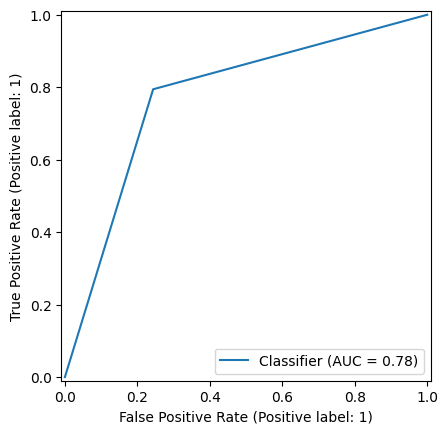

In [ ]:
RocCurveDisplay.from_predictions(y_val, val_pred);

Resultado del modelo inicial: 0.78 (mejor resultado de la competición: 0.88).

## Profundización

A la hora de optimizar un ```RandomForest```, debemos optimizar los mismos parámetros que para un ```DecissionTree``` normal (cuadernillo ```306```).

Además, podemos modificar el parámetro ```n_estimators```, que define la cantidad de árboles del bosque.

A la hora de entrenar este tipo de modelos, puede ser útil utilizar dos búsquedas: exploración y especialiación. Comenzamos con una **exploración** que determine el rango aproximado del mejor parámetro.

In [ ]:
best_model = []
tol = 0.01
tol_acc = 0
max_tol_acc = 3

for k in range(10, 200, 10):
  model = RandomForestClassifier(k, random_state=random_seed)
  model, train_score, test_score, *_ = evaluate(X_train_std, y_train, X_val_std, y_val, model)

  if not best_model or train_score > best_model[0] + tol:
    best_model = [train_score, test_score, model]
    tol_acc = 0
    print(f"Mejor modelo encontrado con {k} árboles. Entrenamiento {train_score} - Evaluación {test_score}")
  elif train_score > best_model[0]:
    print("Solución no adoptada por el uso de la tolerancia")
    tol_acc += 1

  if tol_acc == max_tol_acc or best_model[0] + tol > 1.0: break

Mejor modelo encontrado con 10 árboles. Entrenamiento 0.9887177306159523 - Evaluación 0.7354843509425202
Solución no adoptada por el uso de la tolerancia
Mejor modelo encontrado con 30 árboles. Entrenamiento 0.99907365498366 - Evaluación 0.7642872708573711


Ahora, nos especializamos en esa zona:

In [ ]:
best_model = []
tol = 0.01
tol_acc = 0
max_tol_acc = 3

for k in range(20, 31):
  model = RandomForestClassifier(k, random_state=random_seed)
  model, train_score, test_score, *_ = evaluate(X_train_std, y_train, X_val_std, y_val, model)

  if not best_model or train_score > best_model[0] + tol:
    best_model = [train_score, test_score, model]
    tol_acc = 0
    print(f"Mejor modelo encontrado con {k} árboles. Entrenamiento {train_score} - Evaluación {test_score}")
  elif train_score > best_model[0]:
    print("Solución no adoptada por el uso de la tolerancia")
    tol_acc += 1

  if tol_acc == max_tol_acc or best_model[0] + tol > 1.0: break

Mejor modelo encontrado con 20 árboles. Entrenamiento 0.9972990731222362 - Evaluación 0.7553966995331272


Parece que el mejor bosque tendrá 20 árboles. Vamos a optmizar ahora el resto de parámetros.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
model = RandomForestClassifier(n_estimators=20, random_state=random_seed)
param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": range(2, 20), # quiero provocar cierto sobreajuste
    "min_samples_split": range(2, 20) # muy amplio
}

In [ ]:
rscv = RandomizedSearchCV(model, param_grid, n_iter = 25, n_jobs=-1, scoring="roc_auc", random_state=random_seed, verbose=3)
rscv.fit(X_train_std, y_train);

Fitting 5 folds for each of 25 candidates, totalling 125 fits


Obtengo mis resultados.

In [ ]:
best_params = rscv.best_params_
best_model = rscv.best_estimator_

best_params, best_model

({'min_samples_split': 16, 'max_depth': 13, 'criterion': 'log_loss'},
 RandomForestClassifier(criterion='log_loss', max_depth=13, min_samples_split=16,
                        n_estimators=20, random_state=33))

Obtenemos los resultados para validación.

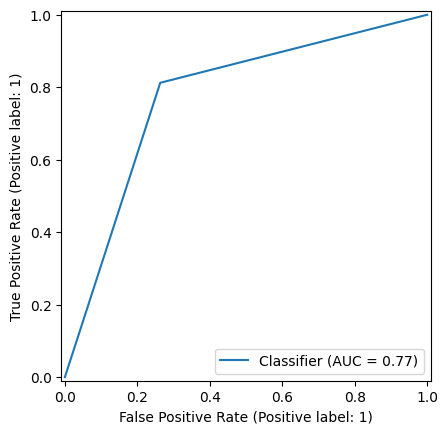

In [ ]:
pred = best_model.predict(X_val_std)
RocCurveDisplay.from_predictions(y_val, pred);

Nuestro modelo optimizado **NO** mejora los parámetros por defecto.

## Otros modelos ensemble

Como hemos dicho previamente, existen muchas formas de crear modelos ensemble. En general, todas ellas parten de la misma idea: establecer un criterio para que varios modelos predigan un resultado. Esto puede hacerse por **democracia**, por **media ponderada**, por **máximos o mínimos** o de cualquier otra forma que genere un resultado verosímil.

Además, estos supermodelos pueden entrenarse de varias formas. La primera idea (y más intuitiva) es entrenarlos por separado y, finalmente, unificarlos. Sin embargo, también podríamos unificarlos y entrenarlos de forma conjunta.

Durante este cuadernillo, cubriremos la forma intuitiva. Es importante tener en cuenta que para unir varios modelos en un supermodelo es un **requisito** que todos ellos tengan un resultado similar (ya sea bueno, malo o mediocre).

### Primera parte del ensemble: KNN

Como KNN es un modelo tan fácil de entrenar, es común que sea siempre una parte del ensemble.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
model = KNeighborsClassifier().fit(X_train_std, y_train)
pred = model.predict(X_val_std)
roc_auc_score(y_val, pred)

np.float64(0.729919217236371)

Optimizamos el KNC.

Como tenemos muchas dimensiones, lo primero que vamos a hacer es buscar otra dimensionalidad mejor para el modelo por defecto.

Como puedes ver, cuantas más dimensiones tenemos, más tardamos en predecir nuestro resultado (a veces, querremos un peor modelo que prediga más rápido).

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
best_score = 0
tol = 0.01

for n in range(1, len(X_train_std[0])):
  pca = PCA(n, random_state=random_seed).fit(X_train_std)
  X_train_pca = pca.transform(X_train_std)
  X_val_pca = pca.transform(X_val_std)

  model = KNeighborsClassifier(n_jobs=-1).fit(X_train_pca, y_train)
  pred = model.predict(X_val_pca)
  score = roc_auc_score(y_val, pred)

  if score > best_score + tol:
    best_score = score
    print(f"Se ha encontrado un nuevo mejor modelo con {n} componentes. Puntuación {score}.")
  elif score > best_score:
    print("No se ha elegido la mejora por el uso de la tolerancia.")

Se ha encontrado un nuevo mejor modelo con 1 componentes. Puntuación 0.6667697758513422.
Se ha encontrado un nuevo mejor modelo con 2 componentes. Puntuación 0.6808092009382878.
No se ha elegido la mejora por el uso de la tolerancia.
No se ha elegido la mejora por el uso de la tolerancia.
No se ha elegido la mejora por el uso de la tolerancia.
Se ha encontrado un nuevo mejor modelo con 6 componentes. Puntuación 0.7056172109695862.
No se ha elegido la mejora por el uso de la tolerancia.
No se ha elegido la mejora por el uso de la tolerancia.
No se ha elegido la mejora por el uso de la tolerancia.
Se ha encontrado un nuevo mejor modelo con 10 componentes. Puntuación 0.7232251246348095.
No se ha elegido la mejora por el uso de la tolerancia.
No se ha elegido la mejora por el uso de la tolerancia.
No se ha elegido la mejora por el uso de la tolerancia.


Aunque el mejor número de componentes sea 10, voy a trabajar con 6 para que vaya más rápido.

In [ ]:
pca = PCA(6, random_state=random_seed).fit(X_train_std)
X_train_pca = pca.transform(X_train_std)
X_val_pca = pca.transform(X_val_std)

Ahora buscamos el mejor número de vecinos.

In [ ]:
best_score = 0
tol = 0.01
acc_tol = 0
max_acc_tol = 3

for n in range(1, len(X_train_std), 2):
  model = KNeighborsClassifier(n, n_jobs=-1).fit(X_train_pca, y_train)
  pred = model.predict(X_val_pca)
  score = roc_auc_score(y_val, pred)

  if score > best_score + tol:
    best_score = score
    acc_tol = 0
    print(f"Se ha encontrado un nuevo mejor modelo con {n} vecinos. Puntuación {score}.")
  elif score > best_score:
    acc_tol += 1
    print("No se ha elegido la mejora por el uso de la tolerancia.")

  if acc_tol == max_acc_tol:
    break

Se ha encontrado un nuevo mejor modelo con 1 vecinos. Puntuación 0.659414682883638.
Se ha encontrado un nuevo mejor modelo con 3 vecinos. Puntuación 0.6896285193177459.
Se ha encontrado un nuevo mejor modelo con 5 vecinos. Puntuación 0.7056172109695862.
No se ha elegido la mejora por el uso de la tolerancia.
Se ha encontrado un nuevo mejor modelo con 9 vecinos. Puntuación 0.717099339853943.
No se ha elegido la mejora por el uso de la tolerancia.
No se ha elegido la mejora por el uso de la tolerancia.
Se ha encontrado un nuevo mejor modelo con 15 vecinos. Puntuación 0.7296167811096864.
No se ha elegido la mejora por el uso de la tolerancia.
No se ha elegido la mejora por el uso de la tolerancia.
No se ha elegido la mejora por el uso de la tolerancia.


Como no obtenemos un resultado sorprendente, dejo de lado el uso de la PCA para facilitarme después el proceso.

In [ ]:
knc = KNeighborsClassifier(15).fit(X_train_std, y_train)

### Segunda parte del ensemble: SVM

Como los SVM trabajan bien con varias columnas y tenemos 17, vamos a ver qué resultados obtenemos al utilizarlo.

In [ ]:
from sklearn.svm import SVC

Antes de nada, vemos su resultado por defecto. Las SVM sufren cuando hay muchas filas, así que la siguiente celda...

**🐭 la siguiente celda puede tardar en ejecutarse (18 minutos)**

In [ ]:
svm = SVC(random_state=random_seed).fit(X_train_std, y_train)
pred = svm.predict(X_val_std)
roc_auc_score(y_val, pred)

np.float64(0.7773961325566048)

Dado que el modelo ha tardado en entrenarse más de 15 minutos y el resultado de su predicción no ha sido especialmente malo, lo usaremos para el ensemble directamente (sin optimizar).

### Tercera parte del ensemble: MLP

Finalmente, trabajaremos con redes neuronales.

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
model = MLPClassifier(random_state=random_seed).fit(X_train_std, y_train)
pred = model.predict(X_val_std)
roc_auc_score(y_val, pred)

np.float64(0.7682353823962618)

Optimicemos la red neuronal.

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(10,), random_state=random_seed)
param_grid = {
    "activation": ["logistic", "tanh", "relu"],
    "learning_rate_init": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    "momentum": [0.5, 0.9, 0.99]
}

**🐭 la siguiente celda puede tardar en ejecutarse (57 minutos)**

In [ ]:
from sklearn.model_selection import GridSearchCV

rscv = GridSearchCV(model, param_grid, n_jobs=-1, scoring="roc_auc", verbose=3)
rscv.fit(X_train_std, y_train);

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [ ]:
best_params = rscv.best_params_
best_model = rscv.best_estimator_

best_params, best_model

({'activation': 'tanh', 'learning_rate_init': 0.001, 'momentum': 0.5},
 MLPClassifier(activation='tanh', hidden_layer_sizes=(10,), momentum=0.5,
               random_state=33))

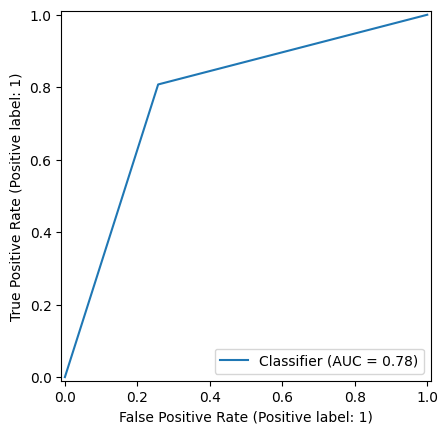

In [ ]:
pred = best_model.predict(X_val_std)
RocCurveDisplay.from_predictions(y_val, pred);

Como puedes observar, no obtenemos ninguna mejora sustancial.

In [ ]:
neural_network = MLPClassifier(hidden_layer_sizes=(10,), activation="tanh", learning_rate_init=0.001, momentum=0.5, random_state=random_seed)
neural_network.fit(X_train_std, y_train)
pred = neural_network.predict(X_val_std)
roc_auc_score(y_val, pred)

np.float64(0.7751477331938341)

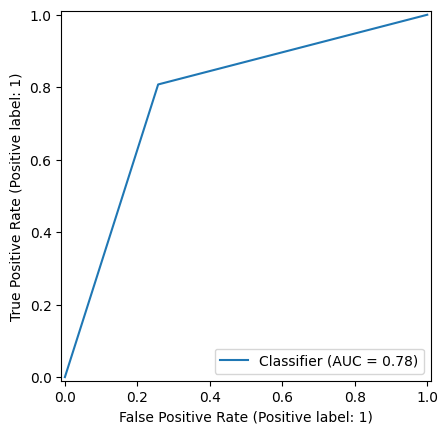

In [ ]:
pred = neural_network.predict(X_val_std)
RocCurveDisplay.from_predictions(y_val, pred);

Parece que estamos atascados en 0.78, no logramos subir de esta marca. ¿Podremos unificar nuestras fuerzas?

### Cuarta parte del ensemble: unión

Habiendo entrenado todas las partes del ensemble que vamos a utilizar, es el momento de unificar sus fuerzas y ponerlos a trabajar juntos.

Ahora, vamos a definir una función que tome todos los modelos y valores y, finalmente, genere un resultado.

In [ ]:
def get_preds(X, *models): # solo de testeo. No tengo que entrenarlo porque ya lo he hecho
  preds = []
  for model in models:
    pred = model.predict(X)
    preds.append(pred)

  return preds

In [ ]:
validation_preds = get_preds(X_val_std, knc, svm, neural_network)
validation_preds

[array([0, 0, 1, ..., 0, 0, 0]),
 array([0, 0, 1, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0])]

Como puedes ver, tenemos predicciones para las que los modelos están _de acuerdo_, pero también podemos observar alguna para las que no. _¿Cómo determinamos la predicción final de nuestro modelo?_

Existen infinitas formas de determinar la solución final, veremos las más comunes:
- **Unanimidad**. Todos los modelos están de acuerdo en que el resultado es **SÍ**, sino, es **NO**. En este caso, nuestra duda en el caso anterior se resolvería como **NO** (0).
- **Consenso**. Al menos un modelo determina que el resultado debería ser **SÍ**. En este caso, nuestra duda se resolvería como **SÍ** (1).
- **Mayoría**. La mayoría de los modelos determinan que el resultado debería ser **SÍ**. Nuestra duda se resolvería como **SÍ** (1).
- **Mayoría ponderada**. Se determina por mayoría, pero algunos modelos tienen más importancia que otros.
- **Cualquier combinación de las anteriores**.

Veamos cómo implementarlo.

In [ ]:
def unanimidad(preds):
  return [min(*v) for v in zip(*preds)] # es el mínimo, porque si uno dice que no, es que NO

In [ ]:
unanimidad_preds = unanimidad(validation_preds)
roc_auc_score(y_val, unanimidad_preds)

np.float64(0.7550043972005143)

Con esta medida, tenemos un resultado peor a los obtenidos al trabajar con modelos separados.

In [ ]:
def consenso(preds):
  return [max(*v) for v in zip(*preds)] # es el máximo, porque si uno dice que sí, es que SÍ

In [ ]:
consenso_preds = consenso(validation_preds)
roc_auc_score(y_val, consenso_preds)

np.float64(0.7757281935625384)

Con esta medida, tenemos un resultado similar a los obtenidos anteriormente.

In [ ]:
def mayoria(preds):
  _preds = [sum(v)/len(v) for v in zip(*preds)] # calculamos la media
  return [0 if v < 0.5 else 1 for v in _preds] # hacemos un threshold

In [ ]:
mayoria_preds = mayoria(validation_preds)
roc_auc_score(y_val, mayoria_preds)

np.float64(0.7774423115271154)

En este caso, esta técnica es igual que la del consenso. Esto puede deberse a que se hayan utilizado modelos con una precisión parecida.

Finalmente, vamos a ver cómo podemos asignar mayor importancia a los modelos. Para ello, podríamos crear una función que tuviese esta forma:

$$
x_1M_1 + x_2M_2+x_3M_3 = \hat{p}
$$

Donde $x_i$ es la importancia del modelo $M_i$ y $\hat{p}$ la predicción final del modelo ensemble.

Estos $x_i$ pueden establecerse a mano (esto daría, posiblemente, un buen resultado), pero... **fíjate**: tenemos una fórmula muy similar a la de una recta en un hiperplano, así que _¡podemos crear un modelo de regresión lineal para establecer estos pesos!_

Vamos a ello.

In [ ]:
from sklearn.linear_model import LinearRegression

La regresión lineal es lo mismo que un **perceptrón**, así que uso esta nueva estrategia para que veas un ejemplo distinto.

In [ ]:
criterion = LinearRegression()

Eso sí, los datos que recibe este modelo **NO** son los datos de nuestro conjunto de datos, sino las predicciones de nuestros modelos del **ensemble**, el objetivo es que establezca qué modelos son más importantes en la decisión. Esta información la podemos calcular con la función ```get_preds``` que hemos definido antes. Los resultados finales (las ```y```) sí podemos reutilizarlas.

**🐭 la siguiente celda puede tardar en ejecutarse (10 minutos)**

In [ ]:
train_preds = get_preds(X_train_std, knc, svm, neural_network)

Antes de entrenar mi ensemble, necesito cambiar la forma de mis predicciones. De [```n_samples```, 3] a [3, ```n_samples```].

In [ ]:
import numpy as np

train_preds = np.array(train_preds).T # la transpuesta

Finalmente, entreno mi criterio.

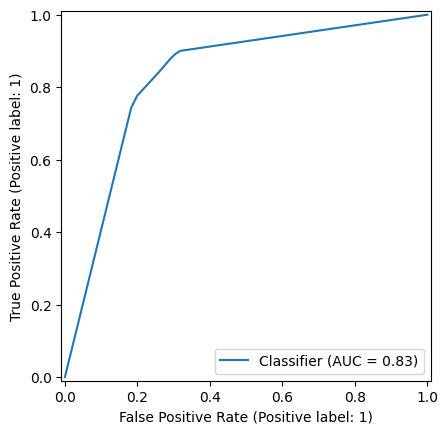

In [ ]:
criterion = criterion.fit(train_preds, y_train) # a partir de las predicciones de los modelos, quiero llegar a la real
ensemble_preds = criterion.predict(train_preds)
RocCurveDisplay.from_predictions(y_train, ensemble_preds); # son las de entrenamiento, pero me pueden dar una idea

No tenemos mal resultado con el entrenamiento, provemos con la validación.

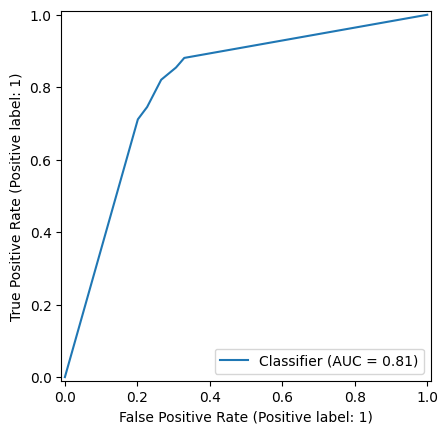

In [ ]:
validation_preds = get_preds(X_val_std, knc, svm, neural_network) # obtengo las predicciones de mis modelos
validation_preds = np.array(validation_preds).T # cambio su forma a la adecuada
ensemble_preds = criterion.predict(validation_preds) # obtengo mi resultado final a partir de mi criterio
RocCurveDisplay.from_predictions(y_val, ensemble_preds); # represento mi resultado final

Hemos mejorado nuestro resultado en un 4% (¡es una buena mejora!).

Ahora faltaría testear el modelo con el conjunto de test y, finalmente, subirlo a Kaggle.

Por cierto, podemos ver los valores de la ponderación usando los atributos ```coef_``` e ```intercept_```.

In [ ]:
criterion.coef_, criterion.intercept_

(array([0.30661316, 0.2226136 , 0.12419324]), np.float64(0.10839265552183314))

Los votos del KNN valen un 33% más que los de la SVM, y éstos un 50% más que los de la red neuronal.

## Otras técnicas ensemble

Como hemos comentado, existen muchas formas distintas de unir nuestros modelos, veremos aquí las tres más comunes que, además, tienen soporte con objetos de la librería ```sklearn```.
- **Bagging**. Se entrenan varios modelos de un solo tipo (por ejemplo, varios árboles de decisión). El ejemplo clásico es el ```RandomForest``` (visto en este cuadernillo).
- **Stacking**. Se entrenan varios modelos de varios tipos y se establece un criterio para seleccionar la predicción final, que combina de alguna forma las predicciones de los modelos. El ejemplo es el visto aquí anteriormente.
- **Boosting**. Se entrenan varios modelos débiles de forma secuencial en serie, de forma que los siguientes modelos intentan mejorar los errores de los modelos previos. Este proceso es avanzado y no lo veremos en el curso, pero existen ejemplos de modelos que funcionan con este ensemble: ```AdaBoost```, ```XGBoost```, ```Gradient Boosting```...

# Resumen

Durante este cuadernillo hemos dado una pincelada rápida a dos de las tres estrategias más famosas para crear modelos ensemble.

Hemos visto los modelos de **bagging**, en particular el más famoso (```RandomForest```).

Después, hemos visto un ejemplo de un modelo **stacking**, que nos ha permitido obtener los mejores resultados del cuadernillo.